In [ ]:
import torch 
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
DATASET = "IMAGENET1K_V1"
##Dictionnary with all the models
models = {
    "VGG11_no_bn" : torchvision.models.vgg11(weights = DATASET),
    "VGG11_bn" : torchvision.models.vgg11_bn(weights = DATASET),
    "Resnet18" : torchvision.models.resnet18(weights = DATASET),
    "Resnet34" : torchvision.models.resnet34(weights = DATASET),
    "Densenet121" : torchvision.models.densenet121(weights = DATASET),
    "MobileNet-v3-Small" : torchvision.models.mobilenet_v3_small(weights = DATASET)
     }
##Dictionnary with Top 1 accuracy on ImageNet for each model
acc_net = {
    "VGG11_no_bn" : 69.02,
    "VGG11_bn" : 70.37,
    "Resnet18" : 69.758,
    "Resnet34" : 73.314,
    "Densenet121" : 74.434,
    "MobileNet-v3-Small" : 67.668
}
##Dictionnary with nb parameters for each model
param_net = {
    "VGG11_no_bn" : 132863336,
    "VGG11_bn" : 132868840,
    "Resnet18" : 11689512,
    "Resnet34" : 21797672,
    "Densenet121" : 7978856,
    "MobileNet-v3-Small" : 2542856
}

##Dictionnary with nb parameters for each model




In [ ]:
##Computation of inference times
def get_inference_time(model, no_grad = True):
  ''' 
  Get the average inference time of a model averaged over 100 iterations
  Arguments : 
    model 
  Return : 
    np.mean(inferences_time) : mean of the 100 inference times measured for each pass
  '''
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  model.eval()
  model = model.to(device)

  inference_times = []
  fake_image = torch.rand((16, 3, 256, 256)).to(device)
  if no_grad == True:
    with torch.no_grad():
      for i in range(1,100):
        torch.cuda
        start.record()
        model(fake_image)
        end.record()
        torch.cuda.synchronize()
        inference_times.append(start.elapsed_time(end))
  else:
    for i in range(1,100):
        start.record()
        model(fake_image)
        end.record()
        torch.cuda.synchronize()
        inference_times.append(start.elapsed_time(end))

  return np.mean(inference_times)

inf_net = {}
for key, item in models.items():
    inf_net[key] = get_inference_time(item, True)

inf_net_grad = {}
for key, item in models.items():
    inf_net_grad[key] = get_inference_time(item, False)






Text(0.5, 1.0, 'Inference time vs number of parameters for several models')

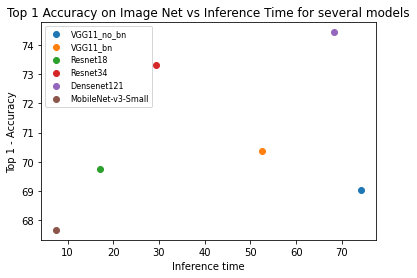

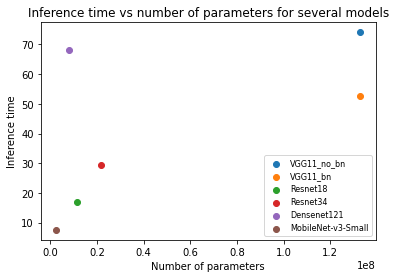

In [ ]:
plt.figure()
for key, _ in models.items():
  plt.scatter(inf_net[key], acc_net[key], label = key)
plt.xlabel("Inference time")
plt.ylabel("Top 1 - Accuracy")
plt.legend(prop={'size': 8})
plt.title("Top 1 Accuracy on Image Net vs Inference Time for several models")

plt.figure()
for key, _ in models.items():
  plt.scatter(param_net[key], inf_net[key], label = key)
plt.xlabel("Number of parameters")
plt.ylabel("Inference time")
plt.legend(prop={'size': 8})
plt.title("Inference time vs number of parameters for several models")

# QUESTION 1.1.A

First trend : the longer the inference time, the higher the accuracy on Image Net. It would make sens because more inference time means more computations so deeper models with more parameters that are supposedly more efficient.

The second trend is the higher the number of parameters, the higher the inference time. It would make sense as more parameters needs more computations, which take indeed more time. One good example is VGG11 that has a lower inference time without batch normalization, as it does less computation than with batch normalization.

# Question 1.1.B

When the gradients are not disabled, the model has to save the values of the gradients in the memory, even if they are not used. So it adds a step to the forward pass, hence it should take more time.

torch.no_grad() disables the gradient computation that are not useful for inference.

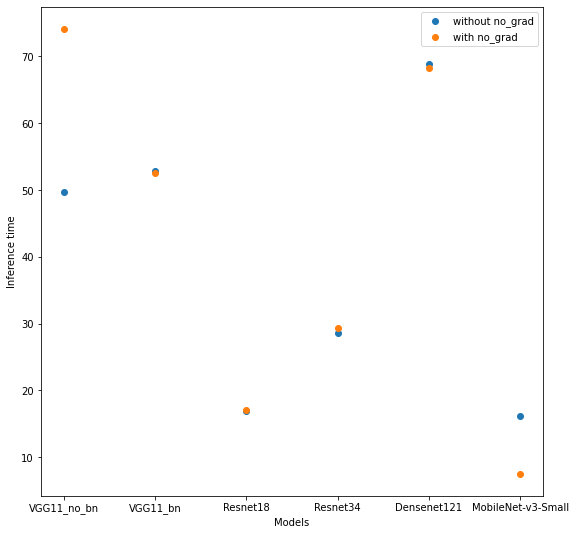

In [ ]:
plt.figure(figsize = (9,9))
plt.scatter(list(models.keys()), inf_net_grad.values(), label = "without no_grad")
plt.xlabel("Models")
plt.ylabel("Inference time")
plt.scatter(list(models.keys()), inf_net.values(), label = "with no_grad")
plt.title("")
plt.legend()



# Question 1.1.C

In [ ]:
def get_memory_allocated(model, no_grad = True):
  ''' 
  Get the allocated memory after a forward pass of a model
  Arguments : 
    model
    no_grad : True if no gradients and False if with gradients
  Returns : 
    memory_2 - memory_2 : memory allocated after a forward pass
  '''
  torch.cuda.empty_cache()
  fake_image = torch.rand((64, 3, 256, 256)).to(device)
  model = model.to(device)
  model.eval()

  if no_grad == True:
    with torch.no_grad():
      memory_1 = torch.cuda.memory_allocated()
      y = model(fake_image)
      memory_2 = torch.cuda.memory_allocated()
      return memory_2 - memory_1
  else:
    memory_1 = torch.cuda.memory_allocated()
    y = model(fake_image)
    memory_2 = torch.cuda.memory_allocated()
    return memory_2 - memory_1

memory_net = {}
for key, item in models.items():
    memory_net[key] = get_memory_allocated(item, True)

memory_net_grad = {}
for key, item in models.items():
    memory_net_grad[key] = get_memory_allocated(item, False)





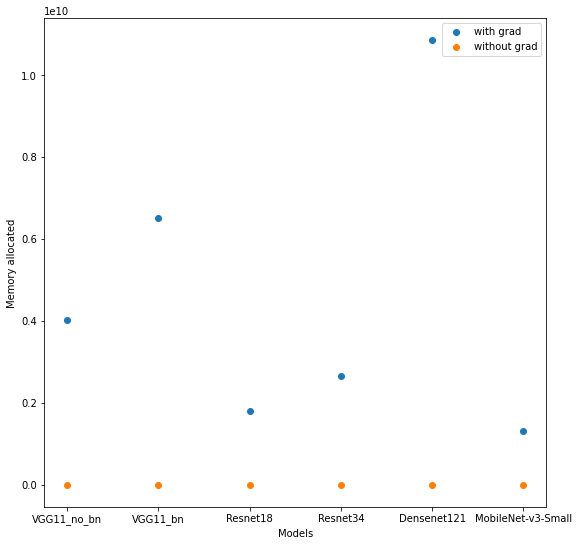

In [ ]:
plt.figure(figsize = (9,9))
plt.scatter(list(models.keys()), memory_net_grad.values(), label = "with grad")
plt.xlabel("Models")
plt.ylabel("Memory allocated")
plt.scatter(list(models.keys()), memory_net.values(), label = "without grad")
plt.title("")
plt.legend()

# QUESTION 1.2.A



In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms

    
def get_dataloader(dataset, batch_size, return_numpy=False):
    collate_fn = numpy_collate_fn if return_numpy else None
    train_dataloader      = DataLoader(dataset=dataset["train"], batch_size=batch_size, shuffle=True, drop_last=True,
                                       collate_fn=collate_fn)
    validation_dataloader = DataLoader(dataset=dataset["validation"], batch_size=batch_size, shuffle=False, drop_last=False,
                                       collate_fn=collate_fn)
    test_dataloader       = DataLoader(dataset=dataset["test"], batch_size=batch_size, shuffle=False, drop_last=False,
                                       collate_fn=collate_fn)
    return {"train": train_dataloader, "validation": validation_dataloader, "test": test_dataloader}


def numpy_collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch], dim=0).numpy()
    labels = np.array([b[1] for b in batch], dtype=np.int32)
    return imgs, labels


def read_data_sets(data_dir, validation_size=5000):
    """
    Returns the dataset readed from data_dir.
    Uses or not uses one-hot encoding for the labels.
    Subsamples validation set with specified size if necessary.
    Args:
      data_dir: Data directory.
      one_hot: Flag for one hot encoding.
      validation_size: Size of validation set
    Returns:
      Dictionary with Train, Validation, Test Datasets
    """

    mean = (0.491, 0.482, 0.447)
    std  = (0.247, 0.243, 0.262)

    data_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean, std)
                        ])

    train_dataset = CIFAR10(root=data_dir, train=True, download=True, transform=data_transforms)
    test_dataset = CIFAR10(root=data_dir, train=False, download=True, transform=data_transforms)
    
    # Subsample the validation set from the train set
    if not 0 <= validation_size <= len(train_dataset):
        raise ValueError("Validation size should be between 0 and {0}. Received: {1}.".format(
            len(train_dataset), validation_size))
        
    train_dataset, validation_dataset = random_split(train_dataset, 
                                                     lengths=[len(train_dataset) - validation_size, validation_size],
                                                     generator=torch.Generator().manual_seed(42))

    return {'train': train_dataset, 'validation': validation_dataset, 'test': test_dataset}


def get_cifar10(data_dir='data/', validation_size=5000):
    """
    Prepares CIFAR10 dataset.
    Args:
      data_dir: Data directory.
      one_hot: Flag for one hot encoding.
      validation_size: Size of validation set
    Returns:
      Dictionary with Train, Validation, Test Datasets
    """
    return read_data_sets(data_dir, validation_size)
data_dir = "data"
cifar10 = get_cifar10(data_dir)
cifar10_loader = get_dataloader(cifar10, batch_size=16,
                                                  return_numpy=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
num_classes = 10


model_transfer = torchvision.models.resnet34(weights = DATASET)
model_transfer.fc = nn.Linear(512, num_classes)
nn.init.uniform_(model_transfer.weight, -0.001, 0.001)